In [1]:
%matplotlib inline

In [2]:
from __future__ import division          # use // for integer division
from __future__ import absolute_import   # use from . import
from __future__ import print_function    # use print("...") instead of print "..."
from __future__ import unicode_literals  # all the strings are unicode

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def rastrigin(x):
    a = 10
    return np.sum(x ** 2 + a * (1 - np.cos(2 * np.pi * x)))

/Users/yaai/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/yaai/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


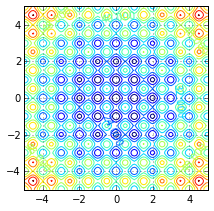

In [6]:
dx, dy = 0.1, 0.1
y, x = np.mgrid[slice(-5, 5 + dy, dy), slice(-5, 5 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = rastrigin(np.array([x[i,j], y[i,j]]))

plt.figure(figsize=(3, 3))
plt.axes((0.1, 0.1, 0.85, 0.85))
plt.axis('equal')
CS = plt.contour(x, y, z, 10)
plt.clabel(CS, inline=1, fontsize=10)
plt.grid()

In [7]:
def bohachevsky(x):
    """bohachevsky function [-15, 15] or [1, 15]"""
    uni = np.sum(x[:-1] ** 2 + 2 * x[1:] ** 2)
    multi = np.sum(0.3 * (1 - np.cos(3 * np.pi * x[:-1])) + 0.4 * (1 - np.cos(4 * np.pi * x[1:])))
    return uni + multi

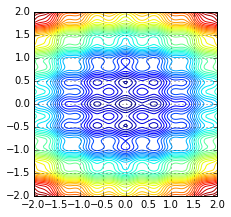

In [8]:
dx, dy = 0.04, 0.04
y, x = np.mgrid[slice(-2, 2 + dy, dy), slice(-2, 2 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = bohachevsky(np.array([x[i,j], y[i,j]]))

plt.figure(figsize=(3, 3))
plt.axes((0.1, 0.1, 0.85, 0.85))
plt.axis('equal')
CS = plt.contour(x, y, z, 50)
plt.grid()

In [9]:
def skewrastrigin(x):
    y = x.copy()
    y[y > 0] *= 10
    return rastrigin(y)

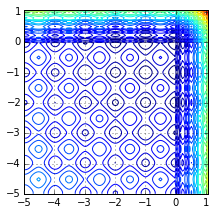

In [10]:
dx, dy = 0.06, 0.06
y, x = np.mgrid[slice(-5, 1 + dy, dy), slice(-5, 1 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = skewrastrigin(np.array([x[i,j], y[i,j]]))

plt.figure(figsize=(3, 3))
plt.axes((0.1, 0.1, 0.85, 0.85))
plt.axis('equal')
CS = plt.contour(x, y, z, 30)
plt.grid()

In [11]:
def bisphere(x):
    ratio = 2
    fsubopt = 1
    xsubopt = 5 * np.ones(x.shape[0])
    return min(ratio * np.sqrt(np.sum(x ** 2)), 
               fsubopt +  np.sqrt(np.sum((x - xsubopt) ** 2)))

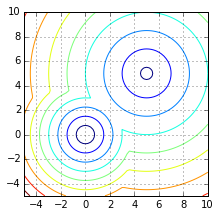

In [12]:
dx, dy = 0.2, 0.2
y, x = np.mgrid[slice(-5, 10 + dy, dy), slice(-5, 10 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = bisphere(np.array([x[i,j], y[i,j]]))

plt.figure(figsize=(3, 3))
plt.axes((0.1, 0.1, 0.85, 0.85))
plt.axis('equal')
CS = plt.contour(x, y, z, 10)
plt.grid()

In [42]:
class CMAES(object):
    """CMA Evolution Strategy with CSA"""
    
    def __init__(self, func, init_mean, init_sigma, nsample):
        """コンストラクタ
        
        Parameters
        ----------
        func : callable
            目的関数 (最小化)
        init_mean : ndarray (1D)
            初期平均ベクトル
        init_sigma : float
            初期ステップサイズ
        nsample : int
            サンプル数
        """
        self.func = func
        self.mean = init_mean
        self.sigma = init_sigma
        self.N = self.mean.shape[0]                     # 探索空間の次元数
        self.arx = np.zeros((nsample, self.N)) * np.nan # 候補解
        self.arf = np.zeros(nsample) * np.nan           # 候補解の評価値
        
        self.D = np.ones(self.N) # 共分散行列の固有値
        self.B = np.eye(self.N)  # 共分散行列の固有ベクトル
        self.C = np.dot(self.B * self.D, self.B.T) # 共分散行列
        
        self.weights = np.zeros(nsample)
        self.weights[:nsample//4] = 1.0 / (nsample//4)  # 重み．総和が1
        
        # For CSA
        self.ps = np.zeros(self.N)
        self.mueff = 1.0 / np.sum(self.weights**2)
        self.cs = (2 + self.mueff) / (3 + self.mueff + self.N)
        self.ds = 1.0 + self.cs + max(1.0, np.sqrt(self.mueff / self.N))
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))
        
        # For CMA
        self.cmu = self.mueff / (self.N ** 2 / 2 + self.N + self.mueff)
        
    def sample(self):
        """候補解を生成する．"""
        self.arz = np.random.normal(size=self.arx.shape)
        self.ary = np.dot(np.dot(self.arz, self.B) * np.sqrt(self.D), self.B.T)
        self.arx = self.mean + self.sigma * self.ary
    
    def evaluate(self):
        """候補解を評価する．"""
        for i in range(self.arf.shape[0]):
            self.arf[i] = self.func(self.arx[i])
        
    def update_param(self):
        """パラメータを更新する．"""
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        # 進化パスの更新 (平均ベクトル移動量の蓄積)
        self.ps = (1 - self.cs) * self.ps + np.sqrt(self.cs * (2 - self.cs) * self.mueff) * np.dot(self.weights, self.arz[idx])
        # 共分散行列の更新
        self.C = (1 - self.cmu) * self.C + self.cmu * np.dot(self.ary[idx].T * self.weights, self.ary[idx])
        # 共分散行列の固有値分解
        self.D, self.B = np.linalg.eigh(self.C)

        # 進化パスの長さが，ランダム関数の下での期待値よりも大きければステップサイズを大きくする．
        self.sigma = self.sigma * np.exp(self.cs / self.ds * (np.linalg.norm(self.ps) / self.chiN - 1))        
        self.mean += np.dot(self.weights, self.arx[idx] - self.mean)

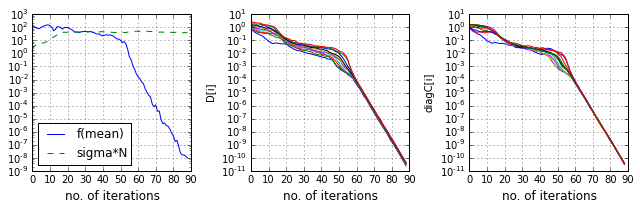

In [121]:
es = CMAES(func=rastrigin,            
           init_mean=-5.0 + 10.0*np.random.rand(10),
           init_sigma=0.1, 
           nsample=1000)             

maxiter = 100
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
D = np.zeros((maxiter, es.N)) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N
    D[i] = es.D
    diagC[i] = np.diag(es.C)
    if mean[i] < 1e-8:
        break

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(132)
plt.semilogy(D)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()
plt.subplot(133)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('diagC[i]')
plt.grid()
plt.tight_layout()

多峰性関数においては，主として以下の三つのパラメータが大きく性能に影響する．

* 初期平均ベクトル
* 初期ステップサイズ
* 集団サイズ

直感的に，以下のことが説明できる．

* ステップサイズがとても小さく平均ベクトルが最適でない局所解に近い場合，局所解の周辺しか探索ができず，近傍の局所解よりもよい局所解が存在することを知り得ない．
* ステップサイズが大きくとも集団サイズが小さければ，偶然発見された評価値の良い局所解近辺の解に探索が集中しやすい．

## 考察

本節に示した４つの関数において，以下のパラメータを変えて実験し，それぞれの関数におけるCMA-ESの振る舞いを確認し，その原因を考察せよ．括弧の中の値は例であり，これに従う必要はない．

* 初期平均ベクトル init_mean ($[-5, 5]^N$)
* 初期ステップサイズ init_sigma ($[0.1, 1, 10]$)
* 集団サイズ nsample ($[10, 100, 1000]$)

ここで，$N$は次元数であり，init_mean の次元数を変更すれば問題の次元数が変わる．